In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


# Data Prep

loading csv files from google drive

In [ ]:
directory = '/content/drive/My Drive/NBA Season Data/2019-20'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

In [ ]:
files.keys()

dict_keys(['cut', 'box_scores', 'post_up', 'putback', 'hand_off', 'screen_assists', 'assists', 'short_chart', 'height_weight', 'drives', 'off_screen', 'pnr_handler', 'catch_and_shoot', 'spot_up', 'touches', 'isolation', 'pnr_man'])

In [ ]:
for name in files.keys():
  print(f"STAT: {name}")
  files[name].info()
  print()

STAT: cut
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PLAYER    337 non-null    object 
 1   TEAM      337 non-null    object 
 2   CUT FREQ  337 non-null    float64
dtypes: float64(1), object(2)
memory usage: 8.0+ KB

STAT: box_scores
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PLAYER  529 non-null    object 
 1   TEAM    529 non-null    object 
 2   MIN     529 non-null    float64
 3   FGA     529 non-null    float64
 4   3PA     529 non-null    float64
 5   AST     529 non-null    float64
dtypes: float64(4), object(2)
memory usage: 24.9+ KB

STAT: post_up
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  -----

merging dataframes

In [ ]:
players = pd.DataFrame()
for stat in files.keys():
  if players.empty:
    players = files[stat]
  else:
    players = pd.merge(players, files[stat], how="left", on = ["PLAYER", "TEAM"])

players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               337 non-null    object 
 1   TEAM                 337 non-null    object 
 2   CUT FREQ             337 non-null    float64
 3   MIN                  304 non-null    float64
 4   FGA                  304 non-null    float64
 5   3PA                  304 non-null    float64
 6   AST                  304 non-null    float64
 7   POST UPS             304 non-null    float64
 8   PUTBACK FREQ         277 non-null    float64
 9   HANDOFF FREQ         194 non-null    float64
 10  SCREEN ASSISTS       304 non-null    float64
 11  PASSES MADE          304 non-null    float64
 12  AGE                  176 non-null    float64
 13  RESTRICTED FGA       176 non-null    float64
 14  IN THE PAINT FGA     176 non-null    float64
 15  MID RANGE FGA        176 non-null    flo

In [ ]:
directory = '/content/drive/My Drive/NBA Season Data/2019-20'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

players18_19 = pd.DataFrame()
for stat in files.keys():
  if players18_19.empty:
    players18_19 = files[stat]
  else:
    players18_19 = pd.merge(players18_19, files[stat], how="left", on = ["PLAYER", "TEAM"])

players18_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               337 non-null    object 
 1   TEAM                 337 non-null    object 
 2   CUT FREQ             337 non-null    float64
 3   MIN                  304 non-null    float64
 4   FGA                  304 non-null    float64
 5   3PA                  304 non-null    float64
 6   AST                  304 non-null    float64
 7   POST UPS             304 non-null    float64
 8   PUTBACK FREQ         277 non-null    float64
 9   HANDOFF FREQ         194 non-null    float64
 10  SCREEN ASSISTS       304 non-null    float64
 11  PASSES MADE          304 non-null    float64
 12  AGE                  176 non-null    float64
 13  RESTRICTED FGA       176 non-null    float64
 14  IN THE PAINT FGA     176 non-null    float64
 15  MID RANGE FGA        176 non-null    flo

In [ ]:
from sklearn.base import TransformerMixin, ClusterMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

class CleanDataset(TransformerMixin):

  def fit(self, X, y=None):
    return self

  def height_to_inches(self, height):
    ft, inches = height.split('-')
    return int(ft) * 12 + int(inches)

  def transform(self, X, y=None):
    # fill NULL stats
    X.fillna(0, inplace=True)

    # filter out players with less than 15 minutes
    X = X.loc[X['MIN'] >= 15,]

    # convert height
    X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)

    #convert all columns to numeric
    numeric_columns = X.columns.difference(['PLAYER', 'TEAM'])
    X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)

    return X

class NormalizeDataset(TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):

    # Normalize 'SCREEN ASSISTS'
    X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] = X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] / X['AST']

    # Normalize 'PASS OFF DRIVE' when 'DRIVES' is not 0
    X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] = X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] / X.loc[X['DRIVES'] != 0, 'DRIVES']

    # Normalize columns in cols_norm_touches
    cols_norm_touches = ['AST', 'PASSES MADE', 'DRIVES', 'FRONT CT TOUCHES', 'ELBOW TOUCHES', 'PAINT TOUCHES']
    for stat in cols_norm_touches:
        X.loc[:, stat] = (X[stat] / X['TOUCHES']) * 100

    # Rename columns related to touches
    X.rename(columns={'AST': 'AST PER TOUCHES', 'PASSES MADE': 'PASSES PER TOUCHES', 'DRIVES': 'DRIVES PER TOUCHES', 'FRONT CT TOUCHES': 'FRONT CT TOUCH FREQ', 'PAINT TOUCHES':'PAINT TOUCHES FREQ', 'ELBOW TOUCHES':'ELBOW TOUCH FREQ'}, inplace=True)

    # Normalize 'CATCH AND SHOOT 3 FREQ' and 'CORNER 3 FREQ'
    cols_norm_3pa = ['CATCH AND SHOOT 3PA', 'CORNER 3 FGA']
    X['CATCH AND SHOOT 3 FREQ'] = 100 * X['CATCH AND SHOOT 3PA'] / np.where(X['3PA'] != 0, X['3PA'], 1)
    X['CORNER 3 FREQ'] = 100 * X['CORNER 3 FGA'] / np.where(X['3PA'] != 0, X['3PA'], 1)

    # Normalize columns in cols_norm_fga
    cols_norm_fga = ['CATCH AND SHOOT FGA', 'IN THE PAINT FGA', 'MID RANGE FGA', 'CATCH AND SHOOT 3PA', 'CORNER 3 FGA', 'POST UPS']
    for stat in cols_norm_fga:
        X.loc[:, stat] = 100 * X[stat] / X['FGA']

    # Rename columns related to FGA
    X.rename(columns={'CATCH AND SHOOT FGA': 'CATCH AND SHOOT FREQ', 'IN THE PAINT FGA': 'IN THE PAINT FREQ', 'MID RANGE FGA': 'MID RANGE FREQ', 'CATCH AND SHOOT 3PA': 'CATCH AND SHOOT 3 TFREQ', 'CORNER 3 FGA': 'CORNER 3 TFREQ', 'POST UPS': 'POST UPS FREQ'}, inplace=True)

    # Drop unnecessary columns
    X.drop(['MIN', 'FGA', '3PA', 'TOUCHES'], axis=1, inplace=True)

    X.reset_index(inplace=True)
    X.drop('index', axis=1, inplace=True)

    # return numerical portion for scaler (preprocessed dataset will be preserved bc drop creates new df)
    return X

class Cluster(ClusterMixin):
  def __init__(self, kmeans = None, num_clusters = 8) -> None:
    self.kmeans = kmeans
    self.num_clusters = num_clusters

  def fit(self, X, y=None):
    if not self.kmeans:
      print("should fire twice")
      self.kmeans = KMeans(n_clusters=self.num_clusters)
      self.kmeans.fit(X)
    return self

  def transform(self, X, y=None):

    newX = pd.DataFrame()
    # get cluster labels
    print("something")
    newX['CLUSTER'] = self.kmeans.predict(X)

    # get soft cluster distances
    col_names =[f'CLUSTER {i} DISTANCE' for i in range(self.num_clusters)]
    newX.loc[:, col_names] = self.kmeans.transform(X)

    # get silhouette scores
    silhouette_coeffs = silhouette_samples(X, self.kmeans.labels_)
    newX.loc[:,'SILHOUETTE COEFFICIENT'] = silhouette_coeffs

    return newX

cluster_pipeline = Pipeline([('std_scaler', StandardScaler()),
                            ('cluster', Cluster(None, num_clusters=8))])

preprocess_pipeline = Pipeline([('clean', CleanDataset()),
                                ('normalize', NormalizeDataset())])



In [ ]:
# players_clean = preprocess_pipeline.fit_transform(players)
# # players_clean.info()
# clusters = cluster_pipeline.fit_transform(players_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
# result = pd.concat([players_clean, clusters], axis=1)


players18_19_clean = preprocess_pipeline.fit_transform(players18_19)
cluster18_19 = cluster_pipeline.fit_transform(players18_19_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
result18_19 = pd.concat([players18_19_clean, cluster18_19], axis=1)
result18_19

<ipython-input-7-49fd5c76499f>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)
<ipython-input-7-49fd5c76499f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
<ipython-input-7-49fd5c76499f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

should fire twice
something


,PLAYER,TEAM,CUT FREQ,AST PER TOUCHES,POST UPS FREQ,PUTBACK FREQ,HANDOFF FREQ,SCREEN ASSISTS,PASSES PER TOUCHES,AGE,...,CLUSTER,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE,SILHOUETTE COEFFICIENT
0,Rudy Gobert,UTA,27.4,2.459016,8.536585,20.6,0.0,4.600000,77.540984,29.0,...,0,4.420678,11.059274,11.443879,10.395889,7.459044,10.683175,8.847955,12.156996,0.285145
1,Bam Adebayo,MIA,24.0,7.774390,29.090909,8.5,0.0,1.000000,71.798780,23.0,...,4,6.102354,9.297274,8.198722,8.668208,5.030004,8.494999,7.742262,9.759857,0.121829
2,Hassan Whiteside,POR,20.8,2.564103,25.714286,23.3,0.0,3.666667,69.444444,0.0,...,0,2.814439,9.619311,11.454458,9.545266,6.628512,10.217125,6.566856,11.217291,0.337006
3,Jarrett Allen,BKN,26.6,4.030227,3.030303,20.3,0.0,2.750000,75.314861,0.0,...,0,3.024738,9.498220,11.527907,9.586026,7.085251,10.106605,6.892393,11.298352,0.343002
4,Nikola Vucevic,ORL,13.4,5.294118,48.502994,8.5,0.0,1.388889,70.735294,0.0,...,6,4.834177,7.296008,10.116603,7.592837,4.905949,8.284860,4.206287,9.934394,0.131999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Eric Gordon,HOU,2.6,4.249292,2.325581,0.0,8.8,0.266667,53.257790,32.0,...,5,9.813229,5.023060,5.411128,5.127468,6.304396,3.186697,6.630397,7.097140,0.209629
262,Blake Griffin,DET,3.6,5.296950,29.496403,3.9,3.6,0.424242,66.773676,0.0,...,6,6.789532,4.993567,6.669306,6.696453,5.499060,6.060451,4.536618,5.785109,0.014407
263,D.J. Augustin,ORL,1.6,8.409506,0.000000,0.0,5.6,0.043478,75.502742,0.0,...,7,12.243257,7.841651,5.906748,9.790419,10.763557,8.827612,9.714519,3.092600,0.364992
264,Darius Garland,CLE,1.1,6.532663,0.847458,0.0,9.7,0.102564,72.361809,21.0,...,2,11.209145,7.143019,2.350462,7.359853,8.234717,5.751292,8.964977,4.858469,0.252980


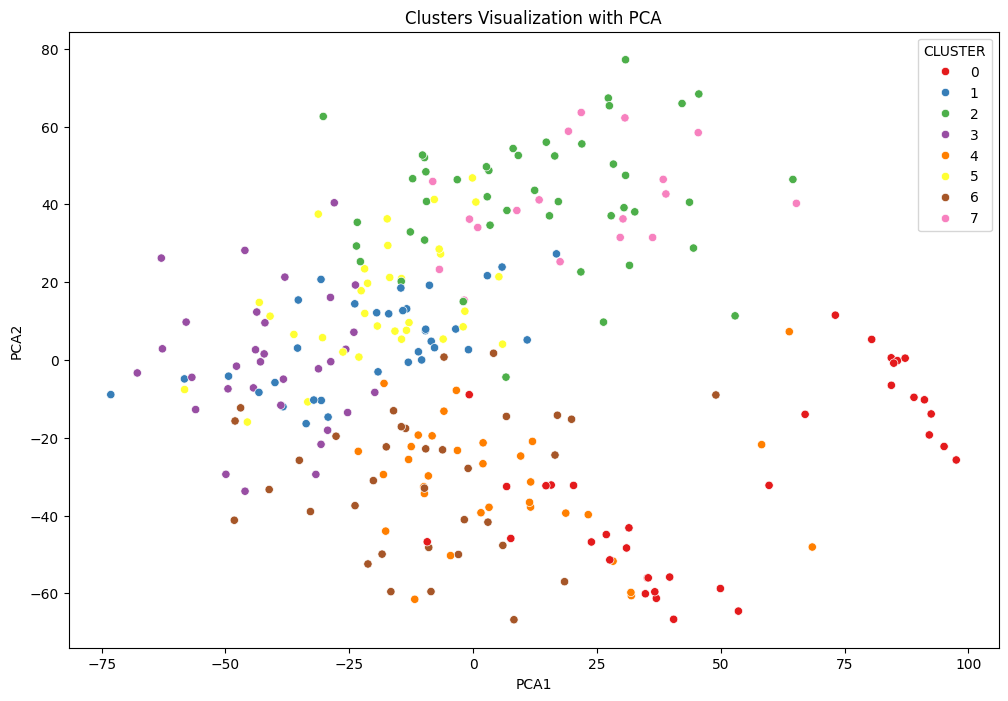

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming result17_18 is your final DataFrame with clustering results
# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(result18_19.drop(['PLAYER', 'TEAM', 'CLUSTER'], axis=1))

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['CLUSTER'] = result18_19['CLUSTER']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='CLUSTER', palette='Set1', data=pca_df, legend='full')
plt.title('Clusters Visualization with PCA')
plt.show()

In [ ]:
# clusters.loc[:,['PLAYER', 'SILHOUETTE COEFFICIENT'] + col_names].sort_values(by=['SILHOUETTE COEFFICIENT'],ascending=False)

In [ ]:
for i in range(8):
  print(f"CLUSTER {i}")
  print(result18_19.loc[result18_19['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
0              Rudy Gobert
2         Hassan Whiteside
3            Jarrett Allen
6         Montrezl Harrell
7             JaVale McGee
9            Dwight Howard
11            Daniel Theis
12           Deandre Ayton
13          Richaun Holmes
14          DeAndre Jordan
16            Jaxson Hayes
19         Bismack Biyombo
20        Tristan Thompson
21             Ivica Zubac
25          Derrick Favors
29             Cody Zeller
30            Nerlens Noel
32            Jakob Poeltl
33       Mitchell Robinson
38            Steven Adams
43      Wendell Carter Jr.
46           Dwight Powell
47            Enes Freedom
57           Mason Plumlee
69             Ian Mahinmi
74            Damian Jones
83              Khem Birch
111          Jahlil Okafor
116       Anzejs Pasecniks
148           Jusuf Nurkic
153         Andre Drummond
173               Alex Len
189            John Henson
198      Cristiano Felicio
239    Willie Cauley-Stein
252         Dewayne Dedmon
Name: PLAYER, dtyp

In [ ]:
cols = [f'CLUSTER {i} DISTANCE' for i in range(8)]
cols = ['PLAYER', 'CLUSTER', 'SILHOUETTE COEFFICIENT'] + cols
result18_19.loc[:, cols]

,PLAYER,CLUSTER,SILHOUETTE COEFFICIENT,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE
0,Aaron Gordon,2,0.014880,3.265769,5.111733,2.504274,3.803850,7.265770,5.904709,4.890954,3.658130
1,Al Horford,3,0.301873,6.291893,5.590068,5.541167,2.732572,7.548201,8.202796,6.968991,5.421791
2,Al-Farouq Aminu,7,0.300008,4.365347,6.126000,5.128297,5.301972,8.700959,7.241339,4.818260,1.937464
3,Alan Williams,4,0.299468,11.113824,6.109186,9.669434,7.608717,3.350551,11.860993,11.902824,9.986391
4,Alec Burks,2,-0.065526,2.867617,6.901382,2.572983,5.798706,8.908344,4.803276,5.192042,4.796224
...,...,...,...,...,...,...,...,...,...,...,...
325,Wilson Chandler,2,0.031028,3.167746,5.876798,2.326750,3.974423,7.902500,5.591371,5.037062,3.966193
326,Yogi Ferrell,5,0.353276,5.257554,9.981207,5.745473,8.671320,11.431688,2.370855,7.948207,8.081787
327,Zach LaVine,0,0.204366,3.562886,8.815746,4.645512,7.425516,10.468189,5.640064,5.153348,6.560295
328,Zach Randolph,3,0.271617,7.913206,4.883514,5.738815,3.054009,5.867054,9.051016,9.064722,7.187671


# 2015-2016 Season Clusters

In [ ]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Display full width

for i in range(8):
  print(f"CLUSTER {i}")
  print(result18_19.loc[result18_19['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
20                Arron Afflalo
22                Avery Bradley
29                 Bradley Beal
36                  Buddy Hield
37                  C.J. Watson
40                 Caris LeVert
42             Chandler Parsons
49                 Courtney Lee
54             Danilo Gallinari
57                   Dante Exum
76                 Devin Harris
87                E'Twaun Moore
93                  Eric Gordon
95                Evan Fournier
98               Garrett Temple
99                  Gary Harris
103            Gerald Henderson
114               Iman Shumpert
115               Isaiah Canaan
128                Jamal Murray
142                Jerian Grant
148                  Joe Ingles
158             Jordan Crawford
159               Jordan Farmar
162             Josh Richardson
176               Kent Bazemore
177    Kentavious Caldwell-Pope
192           Langston Galloway
202               Manu Ginobili
207                Marcus Smart
208             Marcus Thornto